In [1]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [3]:
category_index = label_map_util.create_category_index_from_labelmap('labelmap.pbtxt', use_display_name=True)

In [4]:
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'saved_model')

In [5]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
  
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Pizza
Beer
Beer
Beer


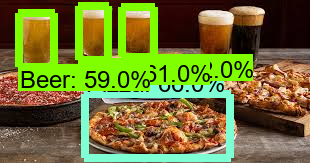

Beer


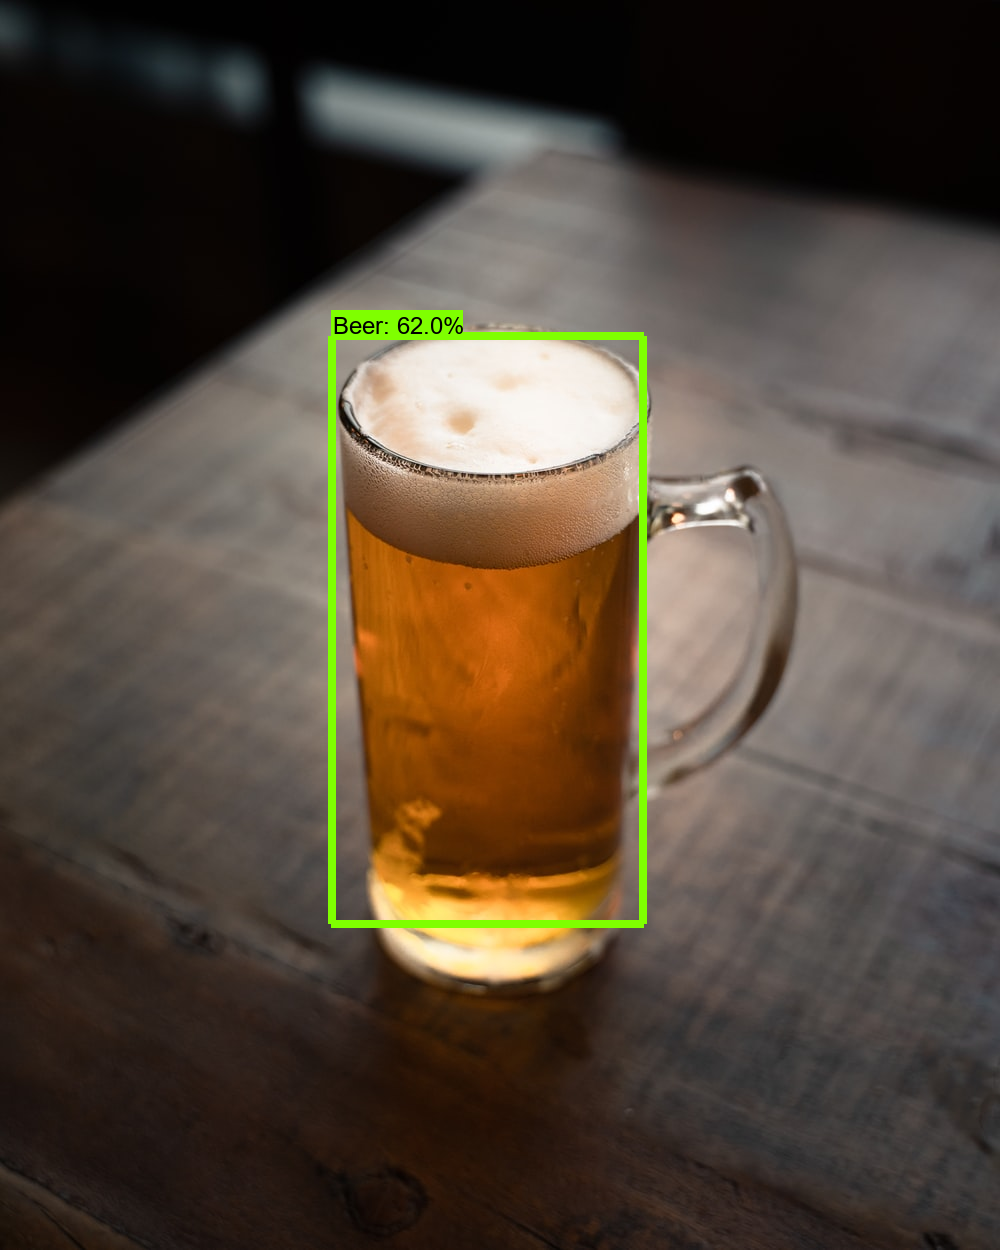

Beer
Beer


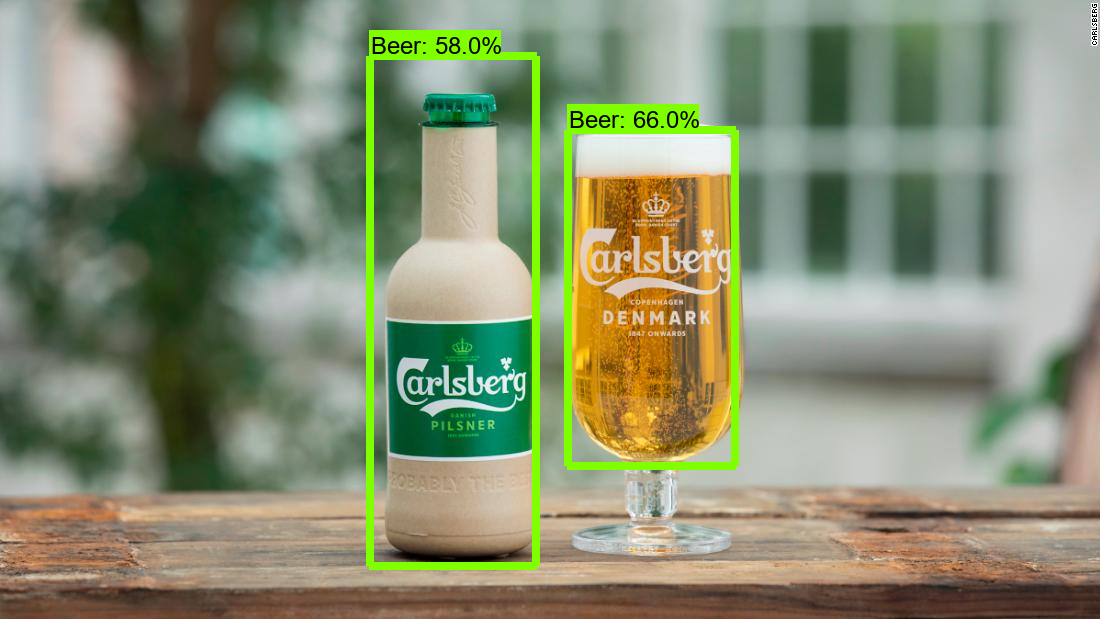

Hamburger


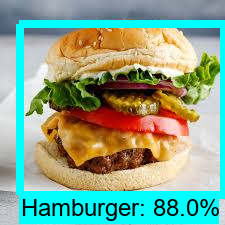

Hamburger


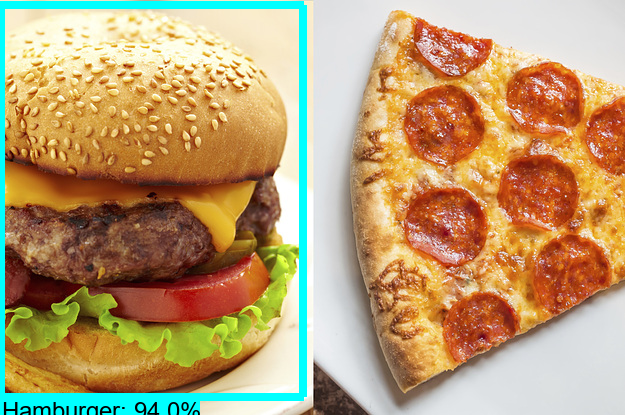

In [7]:
for image_path in glob.glob('images/*.jpg'):
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  for t in output_dict['detection_scores']:
        if t> 0.5:
            k =output_dict['detection_classes'][np.where(output_dict['detection_scores'] == t)]
            print(category_index[int(k)]['name'])
                                                               
  display(Image.fromarray(image_np))

In [8]:
import requests

url= "https://qmazsq3lvj.execute-api.ap-south-1.amazonaws.com/v1Ad/userid/MLTest"
req = requests.get(url = url) 
data=req.json()


item= data["Items"]

image_url = item[0]['url']['S']

result = {'TimeStamp' : item[0]['TimeStamp']['S'],
          'userID' : item[0]['userID']['S'],
          'Meal' : []}


## Importing Necessary Modules
import requests # to get image from the web
import shutil # to save it locally

## Set up the image URL and filename
image_url = item[0]['url']['S']
filename = "1.jpg"

# Open the url image, set stream to True, this will return the stream content.
r = requests.get(image_url, stream = True)

# Check if the image was retrieved successfully
if r.status_code == 200:
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    r.raw.decode_content = True
    
    # Open a local file with wb ( write binary ) permission.
    with open(filename,'wb') as f:
        shutil.copyfileobj(r.raw, f)
        
    print('Image sucessfully Downloaded: ',filename)
else:
    print('Image Couldn\'t be retreived')
    
    
for image_path in glob.glob('1.jpg'):
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  for t in output_dict['detection_scores']:
        if t> 0.5:
            k =output_dict['detection_classes'][np.where(output_dict['detection_scores'] == t)]
            result['Meal'].append(category_index[int(k)]['name'])
            print(category_index[int(k)]['name'])
                                                               
  display(Image.fromarray(image_np))

url = "https://qmazsq3lvj.execute-api.ap-south-1.amazonaws.com/v2/userid/Anish"
no = result['Meal'][0]
response = requests.post(url=url,json={"userID": result["userID"], "TimeStamp":result['TimeStamp'] ,"MealName":no})
for i in range(1,len(result["Meal"])):
    no = result['Meal'][i]
    response = requests.post(url=url,json={"userID": result["userID"], "TimeStamp":str(i) ,"MealName":no})

print(response.text.encode('utf8'))


os.remove("1.jpg")

KeyError: 'url'